# Import the holisticai library

In [11]:
from holisticai.bias.plots import group_pie_plot, frequency_plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from holisticai.bias.metrics import classification_bias_metrics
import pandas as pd
from sklearn import metrics

# Introduction
- The Holistic AI library is an open-source tool to assess and improve the trustworthiness of AI systems. The current version of the library offers a set of techniques to easily measure and mitigate Bias across a variety of tasks.

- In this example we will use the holisticai AI Library (https://www.holisticai.com/open-source) in order to explore potential faireness metrics in a specific given dataset. If you wish to explore further about this library follow the link provided. In this example we will explore fairness analysis for binary classification.

# Data exploration
 First we import and do a simple exploration of the dataset.

In [12]:
df = pd.read_csv('dataset/propublica_data_for_fairml.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6172 entries, 0 to 6171
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Two_yr_Recidivism     6172 non-null   int64
 1   Number_of_Priors      6172 non-null   int64
 2   score_factor          6172 non-null   int64
 3   Age_Above_FourtyFive  6172 non-null   int64
 4   Age_Below_TwentyFive  6172 non-null   int64
 5   African_American      6172 non-null   int64
 6   Asian                 6172 non-null   int64
 7   Hispanic              6172 non-null   int64
 8   Native_American       6172 non-null   int64
 9   Other                 6172 non-null   int64
 10  Female                6172 non-null   int64
 11  Misdemeanor           6172 non-null   int64
dtypes: int64(12)
memory usage: 578.8 KB


##### As we can see above, this dataset is composed of 12 features, where the outcome is the 'Two_yr_Recidivism' 
#####  column, which indicates whether a person commits a crime in the following two years or not. 
#####  The remaining columns include information about the offender’s criminal record, ethnicity, and sex, for example.
#####  Moreover, there are no missing values in the dataset, so we do not need to take any
##### additional action for that.

##### For our purpose, to analyse bias in the model, in this example, we will select the 'Hispanic' 
##### column as our protected attribute, but feel free to select any column that you want to analyse. 
##### As can be seen below, values in the Hispanic column are 0 and 1, where 0 represents that the offender 
##### is not Hispanic and 1 represents that they are Hispanic.

# Using holistic AI library - Initial data analysis
We can use plots from the holisticai library to observe the proportions of the data and then perform a quick exploration.

<AxesSubplot:>

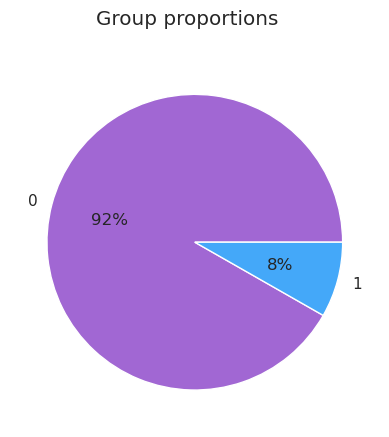

In [13]:
#select the Hispanic column from the dataset
p_attr = df['Hispanic']

#select the recidivism outcome from the dataset
y = df['Two_yr_Recidivism']

#create a plot to show the proportion of the offenders in the dataset that are hispanic
group_pie_plot(p_attr)

<AxesSubplot:xlabel='Group', ylabel='Frequency'>

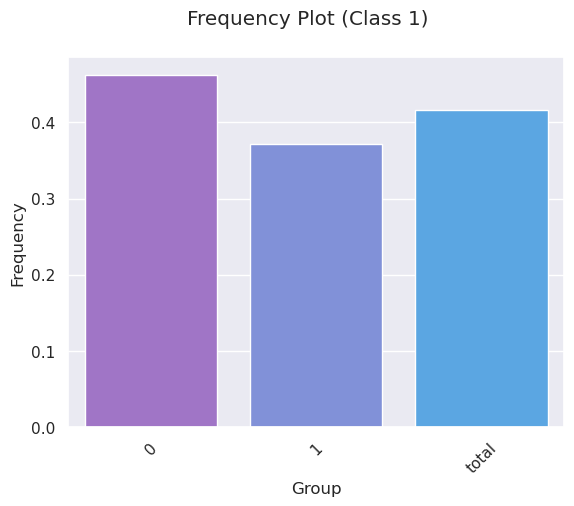

In [14]:
#plot the frequency of people in the Hispanic and non-Hispanic group that reoffend within 2 years
frequency_plot(p_attr, y)

# Using holistic AI library - Model training
In the below example we will explore how we can firstly train a model based on our dataset without the consideration of potential fairness metrics, and then following from this we will use the toolkit to measure our model's prediction performance

We will begin training the model in a traditional way, without considering the influence of any protected attribute and then we will calculate some fairness metrics to assess the predictions of the model.

In [15]:
df_enc = df.copy()

#create a dataframe with only the predictors
X = df_enc.drop(columns=['Two_yr_Recidivism'])
#create a dataframe with only the outcome variable
y = df_enc['Two_yr_Recidivism']

#split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### For this example, we use a traditional logistic regression model.

In [17]:
#create the regression model using training data
LR = LogisticRegression(random_state=42, max_iter=500)
LR.fit(X_train, y_train)
#then use it to predict outcomes using the test data
y_pred = LR.predict(X_test)

#### Next, calculate the metrics with the predicted outcomes

In [18]:
#create the metrics dictionary
metrics_dict={
         "Accuracy": metrics.accuracy_score,
         "Balanced accuracy": metrics.balanced_accuracy_score,
         "Precision": metrics.precision_score,
         "Recall": metrics.recall_score,
         "F1-Score": metrics.f1_score}

#define a metrics dataframe function
def metrics_dataframe(y_pred, y_true, metrics_dict=metrics_dict):
     metric_list = [[pf, fn(y_true, y_pred)] for pf, fn in metrics_dict.items()]
     return pd.DataFrame(metric_list, columns=["Metric", "Value"]).set_index("Metric")

#print the metrics for the test data
metrics_dataframe(y_pred, y_test)

,Value
Metric,
Accuracy,0.665227
Balanced accuracy,0.655317
Precision,0.648045
Recall,0.557692
F1-Score,0.599483


## Bias measuring
Now we need to measure the bias presented in the model with respect to the protected attribute. To calculate the bias of the model, the holisticai library contains a range of useful metrics. To use these functions, we only need to separate the protected attribute from the data and use the predictions with the expected outcomes.

In [19]:
#isolate those who are not Hispanic
group_a = X_test["Hispanic"]==0
#isolate those who are hispanic
group_b = X_test["Hispanic"]==1
#isolate the actual outcomes and predicted outcomes based on the test data
y_pred  = LR.predict(X_test) 
y_true  = y_test

#### Apply classification bias

The library includes an interesting function classification_bias_metrics that computes a range of relevant classification bias metrics such as Statistical parity, Disparate impact, and so on, and displays them as a chart where fair reference values are included for comparison. The function allows us to select the metrics we want to calculate by specifying equal_outcome, equal_opportunity or both. For this example, we will calculate all the metrics, and then pass both as the value in the metric_type parameter


In [21]:
classification_bias_metrics(group_a, group_b, y_pred, y_true, metric_type='both')

,Value,Reference
Metric,,
Statistical Parity,0.190196,0
Disparate Impact,1.897487,1
Four Fifths Rule,0.527013,1
Cohen D,0.392790,0
2SD Rule,4.599563,0
Equality of Opportunity Difference,0.225641,0
False Positive Rate Difference,0.117001,0
Average Odds Difference,0.171321,0
Accuracy Difference,-0.018392,0


These metrics help us to determine whether the model is biased or not.  For example, for the statistical parity metric, values lower than -0.1 or higher than 0.1 indicate bias. For the disparate impact, values lower than 0.8 or higher than 1.2 indicate bias. As we can see, the library presents us with not only the calculated values for the fairness metrics but also the reference values which indicate an ideal debiased AI model. Therefore, the closer the values are to the reference, the fairer our model is.

Given the values from this table, we can clearly observe that the model is biased against Hispanics, who are predicted to re-offend at a higher rate than non-Hispanics. The remaining metrics also provide us with interesting information, with both the Four-Fifths rule, which is widely used in selection and indicates the presence of different outcomes for different subgroups and the Equality of Opportunity Difference, which indicates the difference between the true positive rates of privileged and unprivileged groups, both being violated and indicating bias. You can find more details of the metrics in the reference of the library.